Data Preparation for LSTM

In [1]:
import sys
sys.path.append('../src')  # Point to /src

import importlib
import data_loader
importlib.reload(data_loader)

df = data_loader.load_and_preprocess_data('../data/sp500.csv')
df.to_csv('../data/enriched_stock_data.csv', index=False)

Columns after stripping whitespace:
['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Columns after stripping whitespace:
['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_50', 'Volume_change', 'RSI_14']


In [2]:
import numpy as np
import pandas as pd

# Drop unused column
df = df.drop(columns=['Date'])

# Convert all values to numeric (if any string slipped in)
df = df.apply(pd.to_numeric, errors='coerce')

# Replace inf, -inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check how many NaNs are still there (optional debug step)
print("NaNs before dropping:", df.isna().sum())

# Drop rows with any NaNs
df.dropna(inplace=True)

# Final check: assert there are no NaN or infinite values
assert np.isfinite(df.to_numpy()).all(), "Still contains invalid numbers"



NaNs before dropping: Close            0
High             0
Low              0
Open             0
Volume           0
SMA_10           0
SMA_50           0
Volume_change    1
RSI_14           0
dtype: int64


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# df = df.drop(columns=['Date'])
df = df.drop(columns=['Volume'])
df = df.drop(columns=['High'])
df = df.drop(columns=['Low'])
df = df.drop(columns=['Open'])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

def create_multifeature_sequence(data, seq_length=5):
    X=[]
    y=[]
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i,0])
    return np.array(X),np.array(y)

X,y=create_multifeature_sequence(data_scaled,5)

print("Input shape for LSTM (X):", X.shape)
print("Output shape y:", y.shape)
split = int(0.8*len(X))
X_train,X_test = X[:split], X[split:]
y_train, y_test = y[:split],y[split:]



Input shape for LSTM (X): (3847, 5, 5)
Output shape y: (3847,)


LSTM model architecture

In [4]:
import torch
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
    
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out,_=self.lstm(x)
        last_out=lstm_out[:,-1,:]
        output=self.fc(last_out)
        return output
    

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_features = X.shape[2] 
model = StockLSTM(input_size=5).to(device)

In [6]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Reshape training and testing input to (samples, time steps, features)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor= torch .tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [7]:
num_epochs = 100
train_losses = []

from tqdm.notebook import trange

for epoch in trange(num_epochs, desc="Training Epochs"):
    model.train()
    
    outputs=model(X_train_tensor)
    loss=criterion(outputs.squeeze(), y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if(epoch+1)%5 == 0:
        print(f"Epoch [{epoch +1}/{num_epochs}], Loss:{loss.item():.6f}")

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100], Loss:0.032196
Epoch [10/100], Loss:0.028112
Epoch [15/100], Loss:0.024222
Epoch [20/100], Loss:0.018244
Epoch [25/100], Loss:0.011928
Epoch [30/100], Loss:0.004403
Epoch [35/100], Loss:0.001056
Epoch [40/100], Loss:0.002754
Epoch [45/100], Loss:0.001118
Epoch [50/100], Loss:0.000813
Epoch [55/100], Loss:0.001055
Epoch [60/100], Loss:0.000712
Epoch [65/100], Loss:0.000482
Epoch [70/100], Loss:0.000533
Epoch [75/100], Loss:0.000404
Epoch [80/100], Loss:0.000375
Epoch [85/100], Loss:0.000363
Epoch [90/100], Loss:0.000310
Epoch [95/100], Loss:0.000333
Epoch [100/100], Loss:0.000296


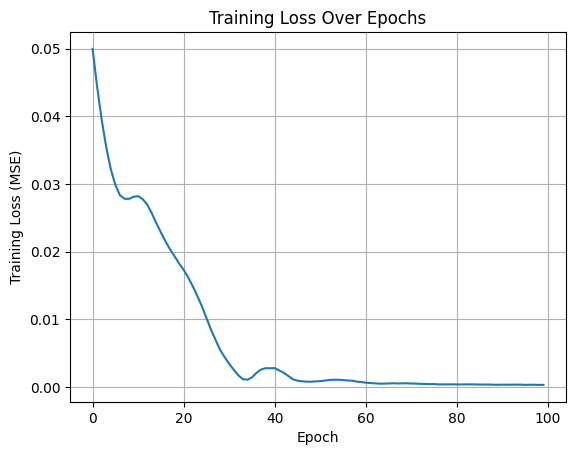

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses)  
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()


In [9]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test).float().to(device))
    test_loss = criterion(y_pred.squeeze(), torch.tensor(y_test).float().to(device))
    print(f"Test Loss: {test_loss.item():.5f}")


Test Loss: 0.00066


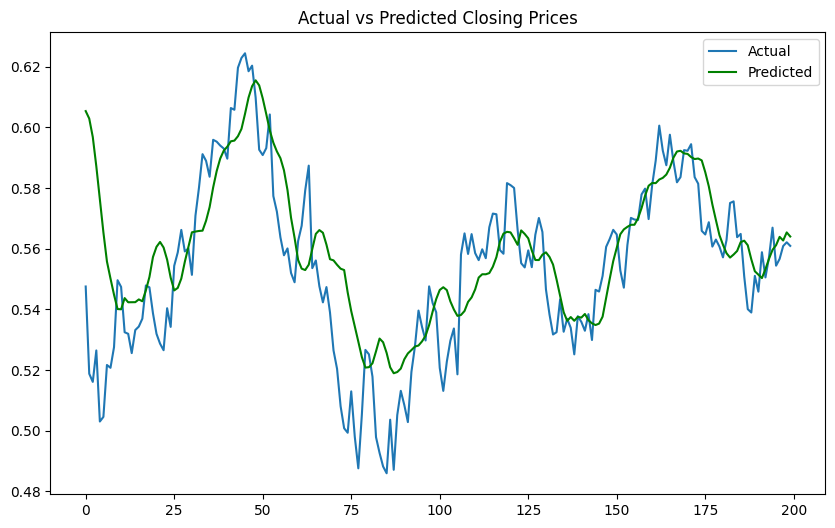

In [10]:
plt.figure(figsize=(10,6))
plt.plot(y_test[:200], label='Actual')
plt.plot(y_pred[:200].cpu().numpy(), label='Predicted', color='green')  # Move to CPU before .numpy()
plt.legend()
plt.title('Actual vs Predicted Closing Prices')
plt.show()


In [11]:
# import torch

# print("Available device:", device)
# print("Is CUDA available?:", torch.cuda.is_available())
# print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")
# next(model.parameters()).device



In [12]:
import os
import torch

# Create output directory if it doesn't exist
os.makedirs('../outputs/saved_models', exist_ok=True)

# Define the save path
model_save_path = '../outputs/saved_models/lstm_stock_model.pth'

# Save the model's state_dict (recommended)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")


Model saved to: ../outputs/saved_models/lstm_stock_model.pth
